# Hello World

Welcome to this hands-on tutorial where we’ll explore the basics of BattMo.jl — a powerful Julia package for simulating lithium-ion battery cells using physics-based models like the Doyle-Fuller-Newman (DFN) model. 

By the end of this tutorial, you’ll:

- Understand how BattMo is structured
- Run your first battery simulation
- Explore and visualize the output
- Learn how to tweak key parameters for custom behavior




Let's activate our previously created environment and import BattMo into the kernel.

In [2]:
import Pkg
Pkg.activate("../") # Activates the environment in the current folder
Pkg.instantiate()

using BattMo, GLMakie

  Activating project at `c:\Users\lorenah\Documents\Repositories\BattMo-workshop-2025-06-13`


### Part 1 - Load input parameters

BattMo.jl structures its simulation inputs into two primary categories: Parameters and Settings. This distinction helps users differentiate between the physical characteristics of the battery system and the numerical configurations of the simulation.

**Parameters** represent the controllable variables in real-world experiments. They are further divided into:

- **Cell Parameters**: define the intrinsic properties of the battery cell, such as geometry and material characteristics.
- **Cycling Protocol Parameters**: specify how the cell is operated during a simulation.

**Settings** are used to configure numerical assumptions for solving equations and finding numerical solutions. They are further divided into:

- **Model Settings**: define numerical assumptions related to the battery model, such as diffusion methods or simplifications used in the simulation.
- **Simulation Settings**: define numerical assumptions specific to the simulation process, including time-stepping schemes and discretization precision:

**BattMo** stores cell parameters, cycling protocols and settings in a user-friendly JSON format to facilitate reuse. We can load the parameters directly from the default sets which can be very convenient for a quick parameter loading to test a simulation setup. In order to quickly see which default sets BattMo provides we can use the following function to print information about the sets available.

In [17]:
print_default_parameter_sets_info()


📁  cell_parameters
Parameter Set       Source    Description
--------------------------------------------------------------------------------
3D_demo_example     -         Parameter set to test P4D simulations. Obtained from the Julia repository but with unknwon source.
Chen2020            ]8;;https://doi.org/10.1149/1945-7111/ab9050visit]8;;     Parameter set of a cylindrical 21700 commercial cell (LGM50), for an electrochemical pseudo-two-dimensional (P2D) model.
Chen2020_calibrated ]8;;https://doi.org/10.1149/1945-7111/ab9050visit]8;;     Parameter set of a cylindrical 21700 commercial cell (LGM50), for an electrochemical pseudo-two-dimensional (P2D) model, after calibration.
SEI_example         -         Parameter set to test SEI simulations. Obtained from the Julia repository but with unknown source.
Xu2015              ]8;;https://doi.org/10.1016/j.energy.2014.11.073visit]8;;     Parameter set of a commercial Type LP2770120 prismatic LiFePO4/graphite cell, for an ele

For our example, we load the cell parameter set from a NMC811 vs Graphite-SiOx cell whose parameters were determined in the [Chen 2020 paper](https://doi.org/10.1149/1945-7111/ab9050). We also load an example cycling protocol for a simple Constant Current Discharge.

In [4]:
cell_parameters = load_cell_parameters(; from_default_set = "Chen2020_calibrated");
cycling_protocol = load_cycling_protocol(; from_default_set = "CCDischarge");

This a quick way of testing a setup, but for the purpose of this workshop we would like to be able to see what a parameter set contains. Therefore, we'll retrieve the default parameter sets that BattMo provides and store them locally in a folder. We can do this by running the following script.

In [5]:
using BattMo: generate_default_parameter_files

path = "."
folder_name = "default_sets"
generate_default_parameter_files(path, folder_name; force = true)

🛠 JSON files successfully written! Path:
	.\default_sets


".\\default_sets"

As we stored the default sets in our own folder, we can alter the default files if we want to and load the parameters from our dedicated folder.

In [8]:
cell_parameters = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/Chen2020_calibrated.json");
cycling_protocol = load_cycling_protocol(; from_file_path = "default_sets/cycling_protocols/CCDischarge.json");

### Part 2 - Select a model setup

Next, we select the default Lithium-Ion Battery setup. A model can be thought as a mathematical implementation of the electrochemical and transport phenomena occuring in a real battery cell. The implementation consist of a system of partial differential equations and their corresponding parameters, constants and boundary conditions. The default Lithium-Ion Battery setup selected below contains the model settings to simulate a basic P2D model, where neither current collectors nor thermal effects are considered.

In [9]:
model_setup = LithiumIonBattery();

✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────


The LithiumIonBattery constructor validates the model settings on the back ground. If the model setup is valid we can continue and create a Simulation object by passing the model setup, cell parameters and a cycling protocol.

### Part 3 - Initiate simulation object

 A Simulation can be thought as a procedure to predict how the cell responds to the cycling protocol, by solving the equations in the model using the cell parameters passed. We first prepare the simulation.

In [11]:
sim = Simulation(model_setup, cell_parameters, cycling_protocol);

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────


The simulation object is only instantiated when the model setup is valid. We can see that the Simulation object also validates the parameters and settings on the back ground. Each parameter set is validated on whether they are sensible and complete. 

### Part 4 - Solve simulation

When the Simulation object is valid we can solve the simulation by passing the object to the solve function. As Julia is a compiled language, the first time that we run a simulation it will take some time to compile the functions and structs that it encounters. The makes running a second simulation very fast. See the difference by running the script for a second time.

In [13]:
output = solve(sim);

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\lorenah\.julia\packages\ProgressMeter\kniaW\src\ProgressMeter.jl:607
Progress 100%|███████████████████████████████████████████| Time: 0:00:00


╭────────────────┬───────────┬───────────────┬──────────╮
│ Iteration type │  Avg/step │  Avg/ministep │    Total │
│                │ 146 steps │ 146 ministeps │ (wasted) │
├────────────────┼───────────┼───────────────┼──────────┤
│ Newton         │   2.32192 │       2.32192 │  339 (0) │
│ Linearization  │   3.32192 │       3.32192 │  485 (0) │
│ Linear solver  │   2.32192 │       2.32192 │  339 (0) │
│ Precond apply  │       0.0 │           0.0 │    0 (0) │
╰────────────────┴───────────┴───────────────┴──────────╯
╭───────────────┬────────┬────────────┬──────────╮
│ Timing type   │   Each │   Relative │    Total │
│               │     ms │ Percentage │       ms │
├───────────────┼────────┼────────────┼──────────┤
│ Properties    │ 0.0387 │     3.01 % │  13.1025 │
│ Equations     │ 0.1860 │    20.71 % │  90.2157 │
│ Assembly      │ 0.1077 │    11.99 % │  52.2132 │
│ Linear solve  │ 0.3156 │    24.56 % │ 106.9717 │
│ Linear setup  │ 0.0000 │     0.00 % │   0.0000 │
│ Precond apply │ 0

### Part 5 - Simple plotting

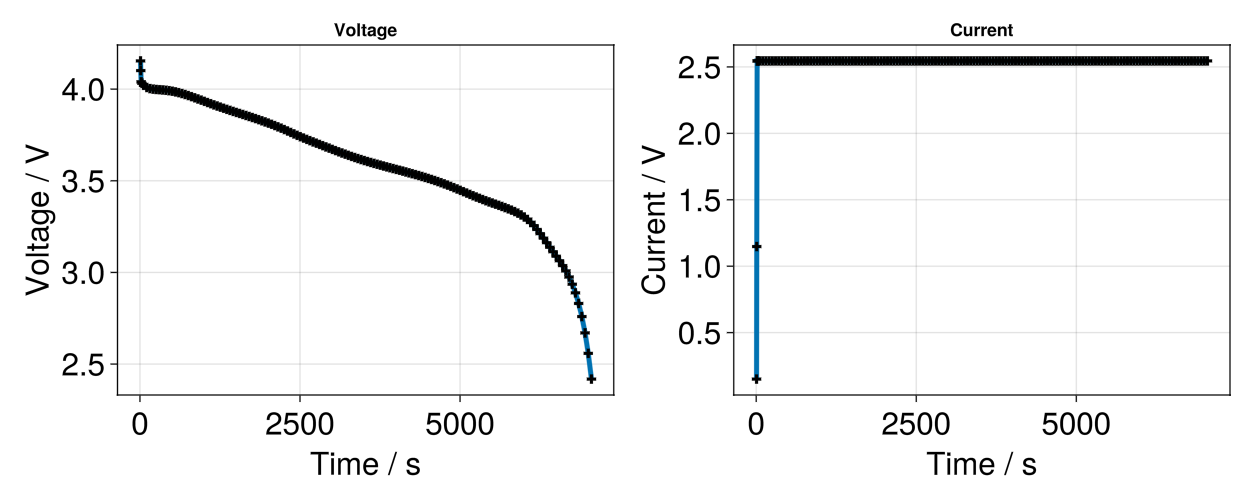

In [14]:


states = output[:states]

t = [state[:Control][:Controller].time for state in states]
E = [state[:Control][:Phi][1] for state in states]
I = [state[:Control][:Current][1] for state in states]
nothing # hide


f = Figure(size = (1000, 400))

ax = Axis(f[1, 1], title = "Voltage", xlabel = "Time / s", ylabel = "Voltage / V",
	xlabelsize = 25,
	ylabelsize = 25,
	xticklabelsize = 25,
	yticklabelsize = 25,
)
scatterlines!(ax, t, E; linewidth = 4, markersize = 10, marker = :cross, markercolor = :black)

f

ax = Axis(f[1, 2], title = "Current", xlabel = "Time / s", ylabel = "Current / V",
	xlabelsize = 25,
	ylabelsize = 25,
	xticklabelsize = 25,
	yticklabelsize = 25,
)
scatterlines!(ax, t, I; linewidth = 4, markersize = 10, marker = :cross, markercolor = :black)

f

### Summary and overview

We learned how to run a simple simulation using default parameters and settings.

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\lorenah\.julia\packages\ProgressMeter\kniaW\src\ProgressMeter.jl:607
Progress 100%|███████████████████████████████████████████| Time: 0:00:00


╭────────────────┬───────────┬───────────────┬──────────╮
│ Iteration type │  Avg/step │  Avg/ministep │    Total │
│                │ 146 steps │ 146 ministeps │ (wasted) │
├────────────────┼───────────┼───────────────┼──────────┤
│ Newton         │   2.32192 │       2.32192 │  339 (0) │
│ Linearization  │   3.32192 │       3.32192 │  485 (0) │
│ Linear solver  │   2.32192 │       2.32192 │  339 (0) │
│ Precond apply  │       0.0 │           0.0 │    0 (0) │
╰────────────────┴───────────┴───────────────┴──────────╯
╭───────────────┬────────┬────────────┬──────────╮
│ Timing type   │   Each │   Relative │    Total │
│               │     ms │ Percentage │       ms │
├───────────────┼────────┼────────────┼──────────┤
│ Properties    │ 0.0415 │     2.88 % │  14.0642 │
│ Equations     │ 0.3957 │    39.29 % │ 191.9018 │
│ Assembly      │ 0.1152 │    11.44 % │  55.8743 │
│ Linear solve  │ 0.3021 │    20.97 % │ 102.4266 │
│ Linear setup  │ 0.0000 │     0.00 % │   0.0000 │
│ Precond apply │ 0

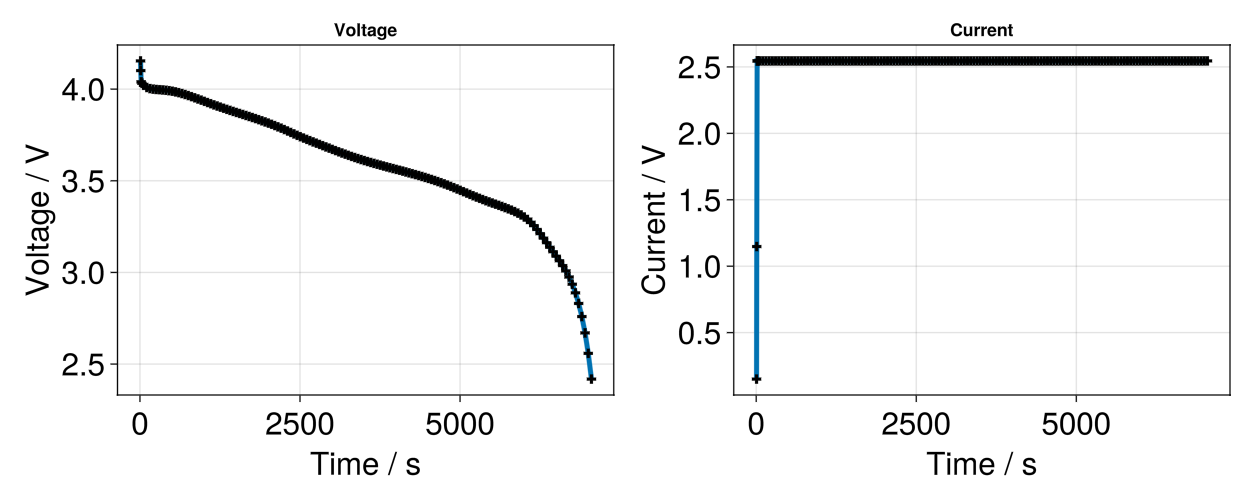

In [16]:
using BattMo, GLMakie

cell_parameters = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/Chen2020_calibrated.json")
cycling_protocol = load_cycling_protocol(; from_file_path = "default_sets/cycling_protocols/CCDischarge.json")

model_setup = LithiumIonBattery()

sim = Simulation(model_setup, cell_parameters, cycling_protocol);

output = solve(sim);

states = output[:states]

t = [state[:Control][:Controller].time for state in states]
E = [state[:Control][:Phi][1] for state in states]
I = [state[:Control][:Current][1] for state in states]
nothing # hide


f = Figure(size = (1000, 400))

ax = Axis(f[1, 1], title = "Voltage", xlabel = "Time / s", ylabel = "Voltage / V",
	xlabelsize = 25,
	ylabelsize = 25,
	xticklabelsize = 25,
	yticklabelsize = 25,
)
scatterlines!(ax, t, E; linewidth = 4, markersize = 10, marker = :cross, markercolor = :black)

f

ax = Axis(f[1, 2], title = "Current", xlabel = "Time / s", ylabel = "Current / V",
	xlabelsize = 25,
	ylabelsize = 25,
	xticklabelsize = 25,
	yticklabelsize = 25,
)
scatterlines!(ax, t, I; linewidth = 4, markersize = 10, marker = :cross, markercolor = :black)

f